# Pacbio consensus gene
This notebook calls consensus muations on PacBio data grouped by by cell_barcode and gene. Then, it exports a processed CSV with the following columns:
* cell_barcode
* gene
* mutations

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

In [2]:
consensus_UMI_csv = 'consensus_UMI.csv.gz' #snakemake.input.consensus_UMI_csv
expt = 'scProgenyPilot_trial3' #snakemake.params.expt
consensus_gene_csv = 'consensus_gene.csv.gz'

Style parameters:

In [3]:
p9.theme_set(p9.theme_classic())

## Load Data

In [4]:
mutations = pd.read_csv(consensus_UMI_csv)
mutations['mutation'] = mutations['mutation'].fillna('None')
display(mutations)

,cell_barcode,gene,UMI,mutation
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,None
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,None
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,G1907A
...,...,...,...,...
1083400,ATTCCATAGTTAGTAG,fluPB2,AAGGAACATTCG,del558to2280
1083401,CGATGGCCAAAGAGTT,fluPB2,CTAACCAGGGGG,None
1083402,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G
1083403,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,del558to2280


## Process Data

Count total UMIs for cell_barcode-gene and count number of UMIs supporting each mutation for cell_barcode-gene:

In [5]:
mutation_UMIs_df = (
    mutations
    .groupby(['cell_barcode', 'gene', 'mutation'])
    ['UMI']
    .nunique()
    .reset_index()
    .rename(columns={'UMI': 'mutation_UMIs'}))
total_UMIs_df = (
    mutations
    .groupby(['cell_barcode', 'gene'])
    ['UMI']
    .nunique()
    .reset_index()
    .rename(columns={'UMI': 'total_UMIs'}))
display(mutation_UMIs_df)
display(total_UMIs_df)

,cell_barcode,gene,mutation,mutation_UMIs
0,AAACGAAGTACTTCCC,fluM,A111C,2
1,AAACGAAGTACTTCCC,fluM,A119G,1
2,AAACGAAGTACTTCCC,fluM,A208G,2
3,AAACGAAGTACTTCCC,fluM,A216T,1
4,AAACGAAGTACTTCCC,fluM,A277G,1
...,...,...,...,...
226177,TTTGGAGGTATCGTTG,fluPB2,T2293A,1
226178,TTTGGAGGTATCGTTG,fluPB2,del2129to2280,2
226179,TTTGGAGGTATCGTTG,fluPB2,ins2128ATCAATGAACTGAGCAATCTTGCAAAAGGAGAGAAGGCT...,1
226180,TTTGGAGGTATCGTTG,fluPB2,ins2292CCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1


,cell_barcode,gene,total_UMIs
0,AAACGAAGTACTTCCC,fluM,432
1,AAACGAAGTACTTCCC,fluNA,146
2,AAACGAAGTACTTCCC,fluNP,727
3,AAACGAAGTACTTCCC,fluNS,461
4,AAACGAAGTACTTCCC,fluPA,7
...,...,...,...
3036,TTTGGAGGTATCGTTG,fluNP,213
3037,TTTGGAGGTATCGTTG,fluNS,113
3038,TTTGGAGGTATCGTTG,fluPA,5
3039,TTTGGAGGTATCGTTG,fluPB1,33


Merge into mutations df:

In [6]:
mutations = pd.merge(
    left=mutations,
    right=mutation_UMIs_df,
    on=['cell_barcode', 'gene', 'mutation'],
    how='left',
    validate='many_to_one'
)
mutations = pd.merge(
    left=mutations,
    right=total_UMIs_df,
    on=['cell_barcode', 'gene'],
    how='left',
    validate='many_to_one'
)
display(mutations)

,cell_barcode,gene,UMI,mutation,mutation_UMIs,total_UMIs
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,None,826,2031
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,None,826,2031
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,6,15
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T,434,441
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,G1907A,6,441
...,...,...,...,...,...,...
1083400,ATTCCATAGTTAGTAG,fluPB2,AAGGAACATTCG,del558to2280,31,82
1083401,CGATGGCCAAAGAGTT,fluPB2,CTAACCAGGGGG,None,60,167
1083402,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G,2,10
1083403,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,del558to2280,4,10


Calculate fraction of total UMIs with mutation:

In [7]:
mutations['frac_UMIs'] = (
    mutations['mutation_UMIs'] /
    mutations['total_UMIs']
)
display(mutations)

,cell_barcode,gene,UMI,mutation,mutation_UMIs,total_UMIs,frac_UMIs
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,None,826,2031,0.406696
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,None,826,2031,0.406696
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,6,15,0.400000
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T,434,441,0.984127
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,G1907A,6,441,0.013605
...,...,...,...,...,...,...,...
1083400,ATTCCATAGTTAGTAG,fluPB2,AAGGAACATTCG,del558to2280,31,82,0.378049
1083401,CGATGGCCAAAGAGTT,fluPB2,CTAACCAGGGGG,None,60,167,0.359281
1083402,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G,2,10,0.200000
1083403,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,del558to2280,4,10,0.400000


## Call consensus
Label consensus mutations if found in >50% of UMIs. This corresponds to `frac_UMIs > 0.5` in our dataframe.

In [8]:
mutations['consensus'] = (
    mutations['frac_UMIs'] > 0.5
)
display(mutations)

,cell_barcode,gene,UMI,mutation,mutation_UMIs,total_UMIs,frac_UMIs,consensus
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,None,826,2031,0.406696,False
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,None,826,2031,0.406696,False
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,6,15,0.400000,False
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T,434,441,0.984127,True
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,G1907A,6,441,0.013605,False
...,...,...,...,...,...,...,...,...
1083400,ATTCCATAGTTAGTAG,fluPB2,AAGGAACATTCG,del558to2280,31,82,0.378049,False
1083401,CGATGGCCAAAGAGTT,fluPB2,CTAACCAGGGGG,None,60,167,0.359281,False
1083402,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G,2,10,0.200000,False
1083403,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,del558to2280,4,10,0.400000,False


## Plot outcomes

Plot distribution of total UMIs per cell_barcode-gene:

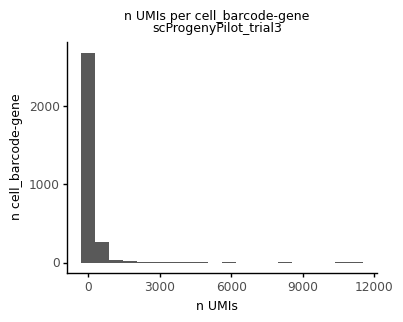

<ggplot: (8792310843179)>

In [9]:
total_UMIs_histo = (
    p9.ggplot(
        (mutations
         [['cell_barcode', 'gene', 'total_UMIs']]
         .drop_duplicates()),
         p9.aes(x='total_UMIs')) +
    p9.geom_histogram(bins=20) +
    p9.ggtitle('n UMIs per cell_barcode-gene\n'
               f'{expt}') +
    p9.labs(x='n UMIs',
            y='n cell_barcode-gene') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center'))

display(total_UMIs_histo)

Plot distribution of UMIs per mutation:

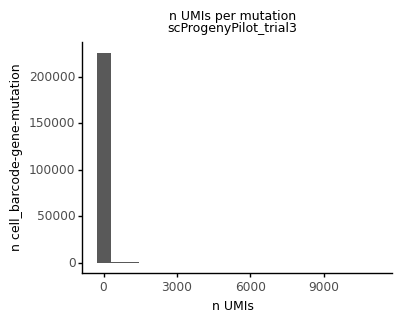

<ggplot: (8792310836369)>

In [10]:
mutation_UMIs_histo = (
    p9.ggplot(
        (mutations
         [['cell_barcode', 'gene', 'mutation', 'mutation_UMIs']]
         .drop_duplicates()),
         p9.aes(x='mutation_UMIs')) +
    p9.geom_histogram(bins=20) +
    p9.ggtitle('n UMIs per mutation\n'
               f'{expt}') +
    p9.labs(x='n UMIs',
            y='n cell_barcode-gene-mutation') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center'))

display(mutation_UMIs_histo)

Plot relationship between the two:

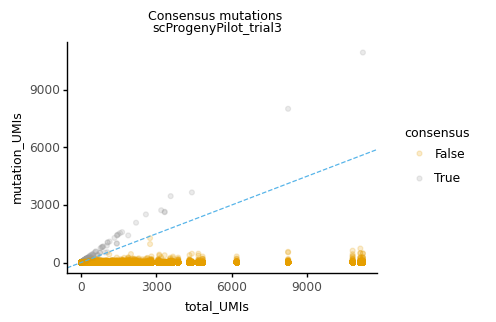

<ggplot: (8792310245684)>

In [11]:
consensus_mutations_scatter = (
    p9.ggplot(
        (mutations
         .query('mutation != "None"')
         [['cell_barcode', 'gene', 'mutation', 'mutation_UMIs', 'total_UMIs', 'consensus']]
         .drop_duplicates()),
         p9.aes(x='total_UMIs',
                y='mutation_UMIs',
                color='consensus')) +
    p9.geom_point(alpha=0.2) +
    p9.geom_abline(intercept=0, slope=0.5, linetype='dashed', color=CBPALETTE[2]) +
    p9.ggtitle('Consensus mutations \n'
               f'{expt}') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center') +
    p9.scale_color_manual([CBPALETTE[1], CBPALETTE[0]]))

display(consensus_mutations_scatter)

## Integrate mutations into genotype

In [12]:
genotypes = (
    mutations
    .query('consensus == True and mutation != "None"')
    .groupby(['cell_barcode', 'gene'])
    ['mutation']
    .unique()
    .reset_index()
    .rename(columns={'mutation': 'consensus_mutations'})
)
genotypes['consensus_mutations'] = (
    genotypes['consensus_mutations']
    .apply(str))

display(genotypes)

,cell_barcode,gene,consensus_mutations
0,AAAGGATTCTGATGGT,fluPB2,['del557to2280']
1,AAAGGGCTCCGCACTT,fluPB2,['del168to2007' 'del2097to2106']
2,AACCAACAGGGTCTTT,fluM,['A111C']
3,AACCAACAGGGTCTTT,fluNA,['del36to1256']
4,AACCAACAGGGTCTTT,fluNS,['G550A']
...,...,...,...
369,TTCTGTAGTTGGGAAC,fluPB2,['del558to2280']
370,TTGCGTCCACCCTCTA,fluHA,['A954G']
371,TTGGGATTCCGATTAG,fluPA,['G885T']
372,TTTCACAAGCCAAGCA,fluHA,['T465A']


Add back into mutations df

In [13]:
mutations = pd.merge(
    left=mutations,
    right=genotypes,
    on=['cell_barcode', 'gene'],
    how='left',
    validate='many_to_one'
)
mutations['consensus_mutations'] = mutations['consensus_mutations'].fillna('None')
display(mutations)

,cell_barcode,gene,UMI,mutation,mutation_UMIs,total_UMIs,frac_UMIs,consensus,consensus_mutations
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,None,826,2031,0.406696,False,None
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,None,826,2031,0.406696,False,None
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,6,15,0.400000,False,None
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T,434,441,0.984127,True,['C63T']
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,G1907A,6,441,0.013605,False,['C63T']
...,...,...,...,...,...,...,...,...,...
1083400,ATTCCATAGTTAGTAG,fluPB2,AAGGAACATTCG,del558to2280,31,82,0.378049,False,None
1083401,CGATGGCCAAAGAGTT,fluPB2,CTAACCAGGGGG,None,60,167,0.359281,False,None
1083402,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G,2,10,0.200000,False,None
1083403,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,del558to2280,4,10,0.400000,False,None


Plot number of cell-gene with or without mutation identified:

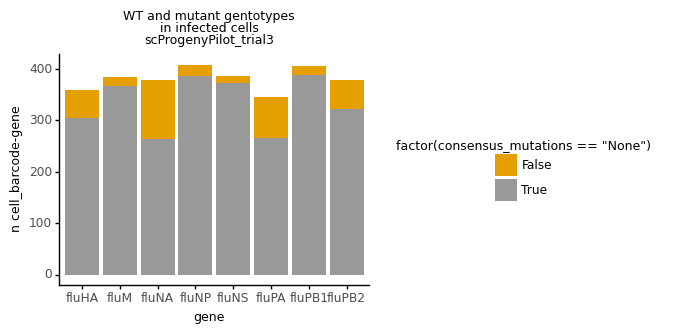

<ggplot: (8792310256541)>

In [14]:
consensus_mutations_per_gene = (
    p9.ggplot(
        (mutations
         [['cell_barcode', 'gene', 'consensus_mutations']]
         .drop_duplicates()),
         p9.aes(x='gene',
                fill='factor(consensus_mutations == "None")')) +
    p9.geom_bar(stat='count') +
    p9.ggtitle('WT and mutant gentotypes\n'
               'in infected cells\n'
               f'{expt}') +
    p9.labs(y='n cell_barcode-gene') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center') +
    p9.scale_fill_manual([CBPALETTE[1], CBPALETTE[0]]))

display(consensus_mutations_per_gene)

Export results

In [15]:
output_df = (
    mutations
    [['cell_barcode', 'gene', 'consensus_mutations']]
    .drop_duplicates()
)
display(output_df)

print(f'Saving UMI consensus mutations to {consensus_gene_csv}')
output_df.to_csv(consensus_gene_csv, index=False)

,cell_barcode,gene,consensus_mutations
0,TATTTCGGTGCCTAAT,fluHA,None
2,TGATTTCCATTGCAAC,fluHA,None
3,GTCGTTCTCGTTTACT,fluHA,['C63T']
7,GTCATTTGTCTACACA,fluHA,None
9,TCAAGTGCAATAGGAT,fluHA,['A158G']
...,...,...,...
1071618,TGCGATACAAACGTGG,fluPB2,['del554to2280']
1075280,GAAGGACAGTGCCTCG,fluPB2,None
1078571,CTACCTGCAGCTGAGA,fluPB2,['ins-17G' 'del1018to2280']
1079814,AATGGAACAAGAATGT,fluPB2,['A559G' 'del562to2280']


Saving UMI consensus mutations to consensus_gene.csv.gz
